In [1]:
from main_pygod import * 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
config_path = 'configs/Base_config.yaml'
config = load_config(config_path)

Loaded configuration from configs/Base_config.yaml
Configuration: {
  "model": {
    "hid_dim": 128,
    "num_layers": 4,
    "dropout": 0.2,
    "weight_decay": 0.0,
    "contamination": 0.1,
    "backbone": "gcn",
    "lr": 0.005,
    "epoch": 20,
    "gpu": -1,
    "batch_size": 2048,
    "num_neigh": 15,
    "weight": 0.5,
    "verbose": 2
  },
  "data": {
    "use_aggregated": false,
    "use_temporal": false,
    "batch_size": 10000,
    "t": 0
  },
  "training": {
    "save_embeddings": false,
    "save_dir": "./saved_models"
  },
  "classifiers": [
    "rf",
    "mlp"
  ],
  "transform": {
    "perturb": false,
    "interpolate": false
  }
}


In [3]:
dataset, input_nodes = load_dataset(
        mask="train",
        use_aggregated=config["data"]["use_aggregated"],
        use_temporal=config["data"]["use_temporal"]
    )

timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")
print(f"Timestamp: {timestamp}")

loader = make_loader(
        data=dataset, 
        loader_type='neighbor', 
        batch_size=config["data"]["batch_size"], 
        input_nodes=input_nodes,
    )

train_data = get_data_from_loader(loader)

train_data = transform_data(train_data, perturb=config['transform']['perturb'], 
                            interpolate=config['transform']['interpolate'])

mymodel = create_model(config=config["model"])

trained_model = train_model(
        mymodel, 
        train_data, 
        output_directory=config["training"]["save_dir"], 
        save_embeddings=config["training"]["save_embeddings"],
        timestamp=timestamp
    )

Timestamp: 2025-04-23_21_12
data loaded from loader:
Data(x=[20165, 93], edge_index=[2, 19924], y=[20165])
creating model with {'hid_dim': 128, 'num_layers': 4, 'dropout': 0.2, 'weight_decay': 0.0, 'act': <function relu at 0x131c37e20>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 20, 'gpu': -1, 'batch_size': 2048, 'num_neigh': 15, 'weight': 0.5, 'verbose': 2, 'backbone': <class 'torch_geometric.nn.models.basic_gnn.GCN'>}
training model...
Epoch 0000: Loss 2724.9001 |  | Time 1.27
Epoch 0001: Loss 917.0506 |  | Time 1.01
Epoch 0002: Loss 715.4120 |  | Time 0.98
Epoch 0003: Loss 312.5062 |  | Time 1.01
Epoch 0004: Loss 110.7026 |  | Time 0.94
Epoch 0005: Loss 76.4020 |  | Time 0.97
Epoch 0006: Loss 40.6233 |  | Time 0.97
Epoch 0007: Loss 29.3112 |  | Time 0.92
Epoch 0008: Loss 34.3234 |  | Time 1.02
Epoch 0009: Loss 33.5144 |  | Time 0.96
Epoch 0010: Loss 24.8462 |  | Time 0.92
Epoch 0011: Loss 27.8593 |  | Time 1.02
Epoch 0012: Loss 26.4462 |  | Time 1.03
Epoch 0013:

In [4]:
dataset, input_nodes = load_dataset(
        mask="test",
        use_aggregated=config["data"]["use_aggregated"],
        use_temporal=config["data"]["use_temporal"]
    )

loader = make_loader(
            data=dataset, 
            loader_type='neighbor', 
            batch_size=config["data"]["batch_size"], 
            input_nodes=input_nodes,

        )    
    
test_data = get_data_from_loader(loader)

data loaded from loader:
Data(x=[15326, 93], edge_index=[2, 14010], y=[15326])


In [5]:
predicted_labels, predicted_probs = trained_model.predict(test_data, return_prob=True)

Test: Loss 0.5683 |  | Time 0.38


In [6]:
true_labels = test_data.y.detach().cpu().numpy()

In [7]:
pred_labels = predicted_labels.detach().cpu().numpy()

In [8]:
emb_np = trained_model.emb.detach().cpu().numpy()

In [9]:
pred_labels.shape

(15326,)

In [10]:
mask = true_labels != 2

In [11]:
true_labels_selected = true_labels[mask]

In [12]:
emb_selected = emb_np[mask]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from sklearn.manifold import Isomap, TSNE, SpectralEmbedding

def visualize_embeddings(embeddings, labels, method='kpca', **kwargs):

    # default params
    params = {
        'kpca': {'n_components': 2, 'kernel': 'rbf'},
        'isomap': {'n_components': 2, 'n_neighbors': 15},
        'tsne': {'n_components': 2, 'perplexity': 30, 'n_iter': 1000},
        'spectral': {'n_components': 2, 'affinity': 'nearest_neighbors'}
    }
    
    if method in params:
        params[method].update(kwargs)
    
    # Apply dimensionality reduction
    if method == 'kpca':
        reducer = KernelPCA(**params[method])
    elif method == 'isomap':
        reducer = Isomap(**params[method])
    elif method == 'tsne':
        reducer = TSNE(**params[method])
    elif method == 'spectral':
        reducer = SpectralEmbedding(**params[method])
    else:
        raise ValueError(f"Method '{method}' not supported. Choose from 'kpca', 'isomap', 'tsne', 'spectral'.")
    
    # Fit and transform the data
    reduced_data = reducer.fit_transform(embeddings)
    
    # Create a scatter plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Get unique labels
    unique_labels = np.unique(labels)
    colors = ['blue', 'red'] # only two classes :D 
    
    # Plot each class with a different color
    for i, label in enumerate(unique_labels):
        mask = labels == label
        color = colors[i % len(colors)] 
        ax.scatter(
            reduced_data[mask, 0],
            reduced_data[mask, 1],
            c=color,
            marker='o',
            label=f'Class {label}',
            alpha=0.7
        )
    
    method_names = {
        'kpca': 'Kernel PCA',
        'isomap': 'Isomap',
        'tsne': 't-SNE',
        'spectral': 'Spectral Embedding'
    }
    
    # Add labels and legend
    plt.title(f'{method_names.get(method, method)} Visualization of Embeddings')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    return fig, reduced_data

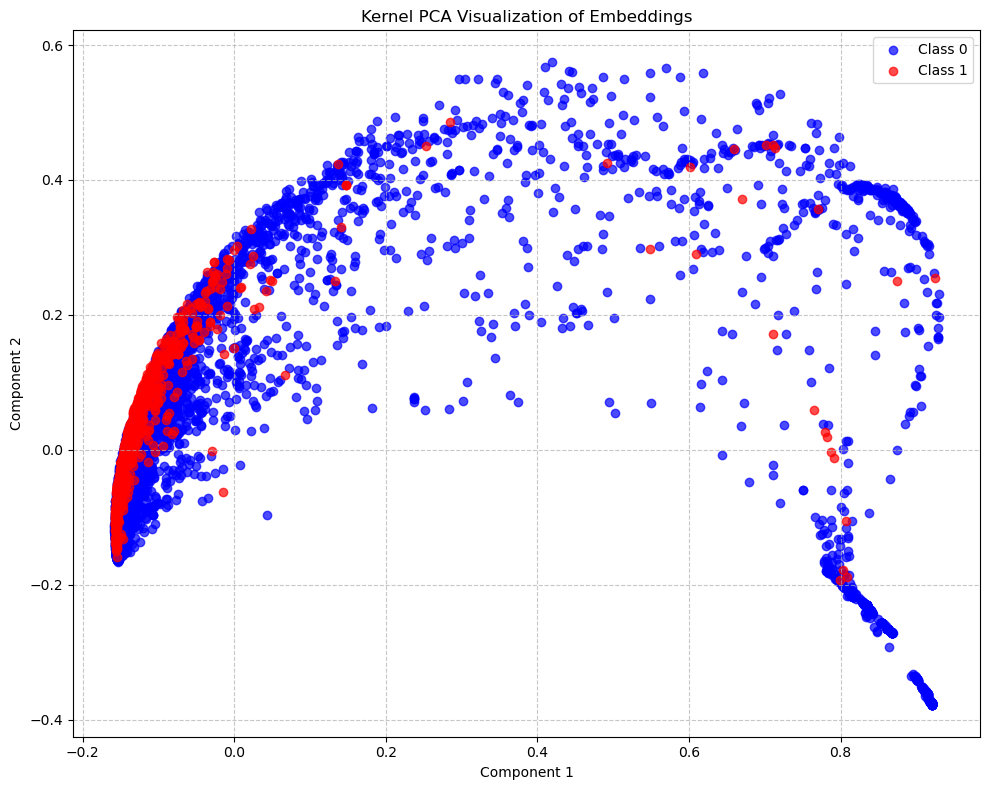

<Figure size 640x480 with 0 Axes>

In [20]:
myplot = visualize_embeddings(emb_selected, true_labels_selected, method='kpca', n_components=2, kernel='rbf')
plt.show()
plt.savefig(f"kpca.png", dpi=300, bbox_inches='tight')

/opt/anaconda3/envs/dl-graph-cpu/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


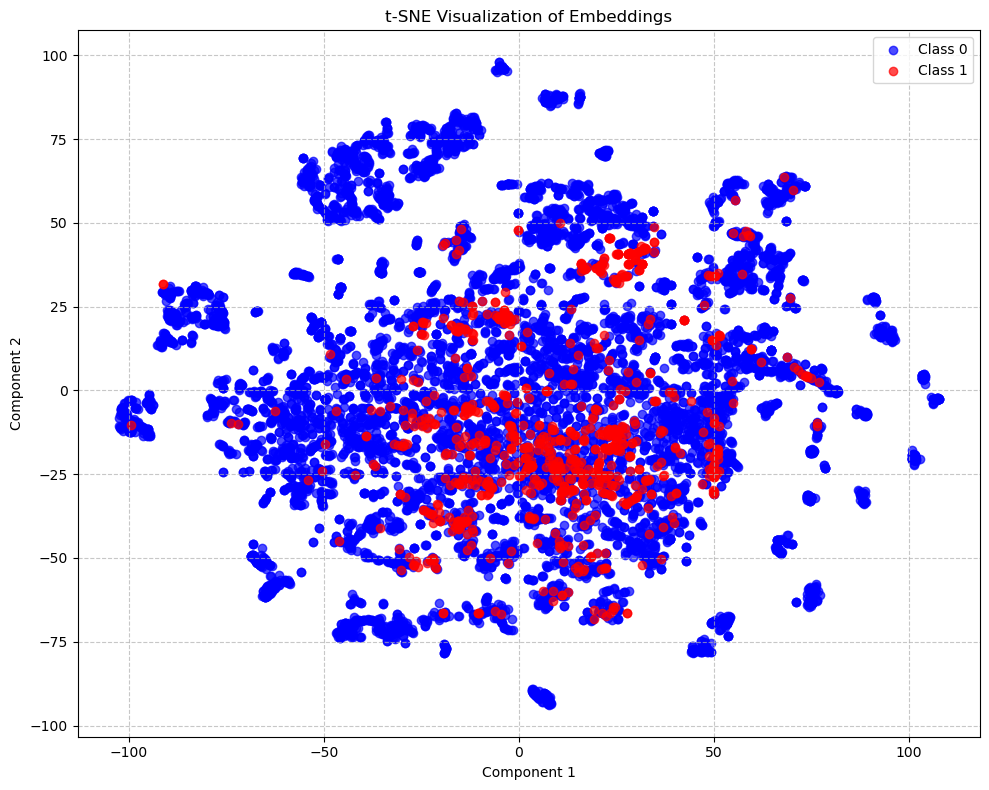

<Figure size 640x480 with 0 Axes>

In [ ]:
myplot = visualize_embeddings(emb_selected, true_labels_selected, method='tsne',)
plt.show()
plt.savefig(f"tsne.png", dpi=300, bbox_inches='tight')

/opt/anaconda3/envs/dl-graph-cpu/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/opt/anaconda3/envs/dl-graph-cpu/lib/python3.10/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/anaconda3/envs/dl-graph-cpu/lib/python3.10/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/anaconda3/envs/dl-graph-cpu/lib/python3.10/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are mo

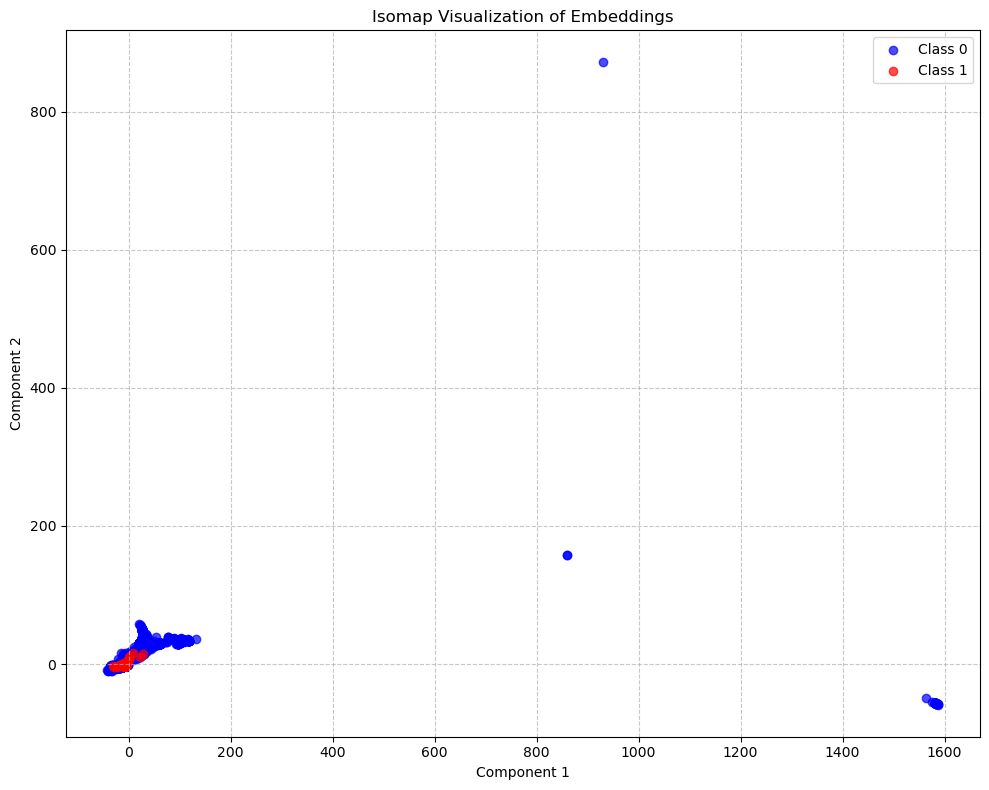

<Figure size 640x480 with 0 Axes>

In [27]:
myplot = visualize_embeddings(emb_selected, true_labels_selected, method='isomap', n_neighbors=10)
plt.show()
plt.savefig(f"isomap.png", dpi=300, bbox_inches='tight')

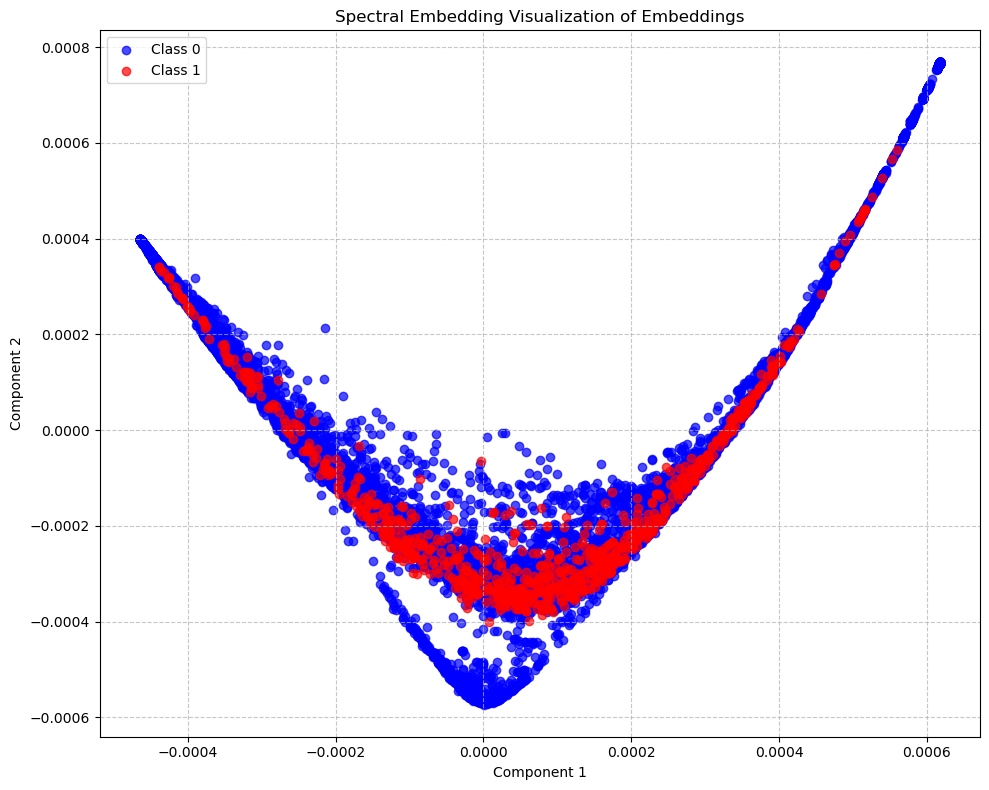

<Figure size 640x480 with 0 Axes>

In [28]:
myplot = visualize_embeddings(emb_selected, true_labels_selected, method='spectral')
plt.show()
plt.savefig(f"spectral.png", dpi=300, bbox_inches='tight')

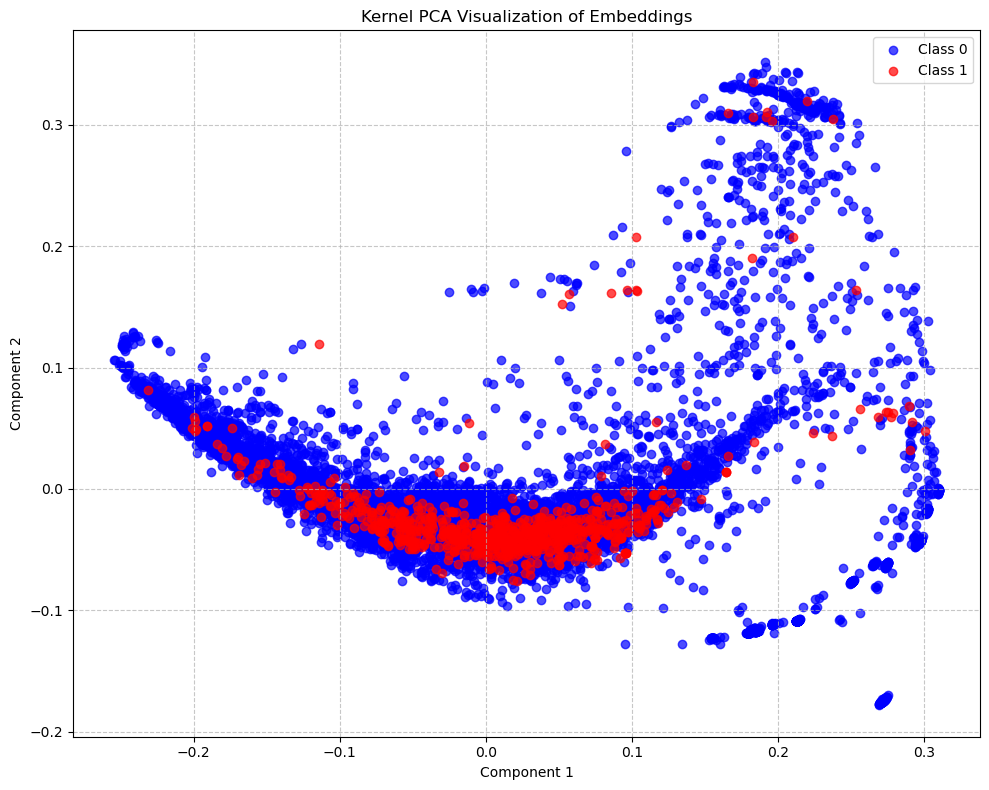

<Figure size 640x480 with 0 Axes>

In [30]:
myplot = visualize_embeddings(emb_selected, true_labels_selected, method='kpca', n_components=2, kernel='sigmoid')
plt.show()
plt.savefig(f"kpca_sigmoid.png", dpi=300, bbox_inches='tight')

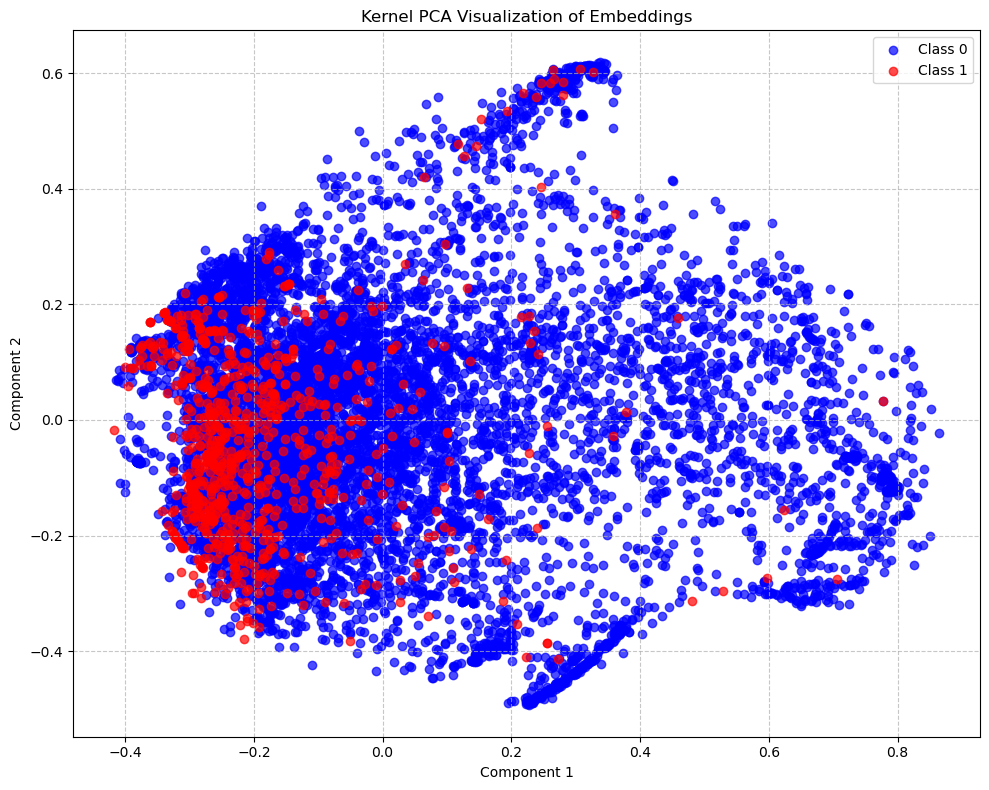

<Figure size 640x480 with 0 Axes>

In [32]:
myplot = visualize_embeddings(emb_selected, true_labels_selected, method='kpca', n_components=2, kernel='cosine')
plt.show()
plt.savefig(f"kpca_cosine.png", dpi=300, bbox_inches='tight')

/opt/anaconda3/envs/dl-graph-cpu/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


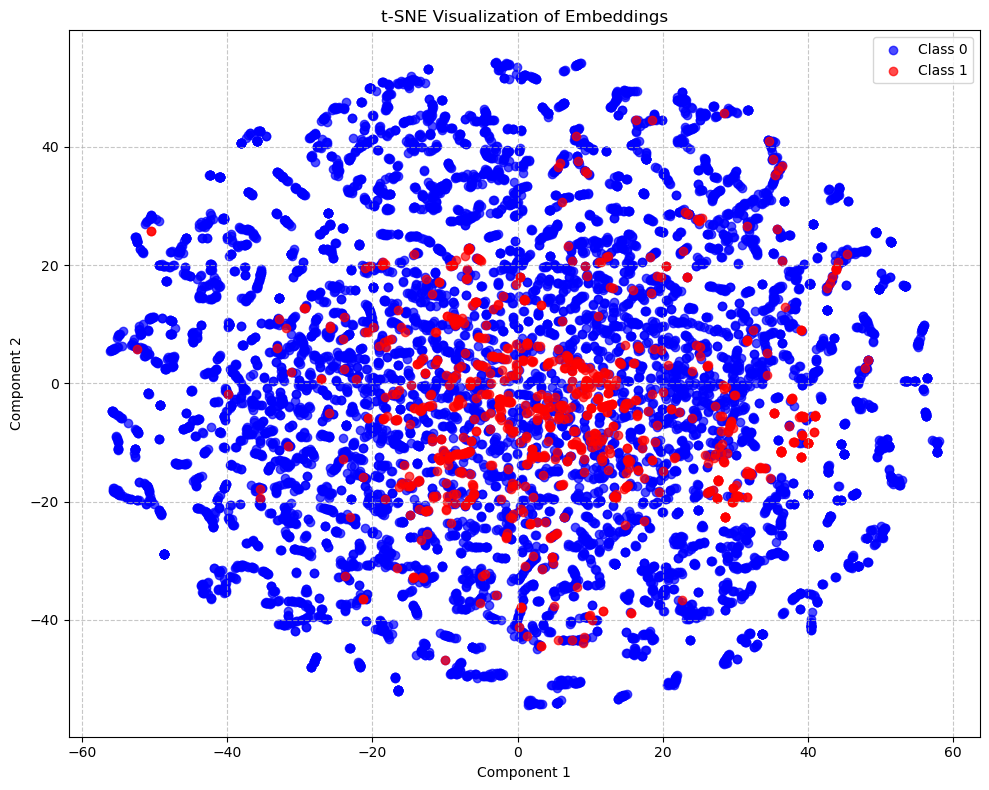

In [42]:
myplot = visualize_embeddings(emb_selected, true_labels_selected, method='tsne', perplexity=10 , n_iter=500)
plt.show()